In [ ]:
# !pip install datasets
# !pip install diffusers
# !pip install accelerate
# !pip install gridspec

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as nnf
import torch.nn.functional as F
import math
import os
import glob
from dataclasses import dataclass
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torch.utils.data import TensorDataset, DataLoader
from datasets import load_dataset
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from torchvision import utils
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
from accelerate import notebook_launcher
from matplotlib import gridspec

In [7]:
@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 32  # how many images to sample during evaluation
    num_epochs = 1
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 100
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-IllustrisTNG-CV"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

class CustomDataset(Dataset):
    def __init__(self, data, parameters, data_conditional=None, augment=True):
        self.data = torch.from_numpy(data)
        self.parameters = torch.from_numpy(parameters)
        self.augment = augment
        if data_conditional is not None:
            self.data_conditional = torch.from_numpy(data_conditional)
        else:
            self.data_conditional = None

    def __getitem__(self, index):
        x = self.data[index]
        y = self.parameters[index]
        if self.data_conditional is not None:
            x_conditional = self.data_conditional[index]
        else:
            x_conditional = None

        if self.augment:
            if np.random.rand() < 0.5:
                x = torch.flip(x, [1, ])
                if x_conditional is not None:
                    x_conditional = torch.flip(x_conditional, [1, ])
            if np.random.rand() < 0.5:
                x = torch.flip(x, [2, ])
                if x_conditional is not None:
                    x_conditional = torch.flip(x_conditional, [2, ])
            k = np.random.choice([0, 1, 2, 3])
            if k > 0:
                x = torch.rot90(x, k=k, dims=[1, 2])
                if x_conditional is not None:
                    x_conditional = torch.rot90(x_conditional, k=k, dims=[1, 2])

        if x_conditional is not None:
            return {"input": x, "parameters": y, "conditional_input": x_conditional}
        else:
            return {"input": x, "parameters": y}

    def __len__(self):
        return len(self.data)

class CustomDataset(Dataset):
    def __init__(self, data, parameters, augment = False):
        self.data = torch.from_numpy(data)
        self.parameters = torch.from_numpy(parameters)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        #x = torch.view_as_real(x)
        y = self.parameters[index]

        sample = {"image": x} #Since we are doing unconditional image generation, no need for the labels

        return sample

In [8]:
def normalise(img):
  """
  Normalises values between -1 and 1.
  """
  norm = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
  return 2 * norm - 1

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    #see pipeline outputs for the np output - add output_type="np.array"

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    #save the image tensors (?) - This does not save the tensors, but a list of the image objects
    im_tens = images
    torch.save(im_tens, "im_tens.pt")
    #imarray = save_image_array(images)
    #np.save("imarray.npy", imarray) #this breaks the training loop

    # Save the images
    #Need a better way of doing this - I would prefer if we found a way to save the image tensors here instead of using PIL pngs, but this might not be possile
    # Tensors can be read quicker and without the same fuss that PIL does
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

def train_loop(config, model, noise_scheduler, optimizer, dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps)#,
        #log_with="tensorboard",
        #logging_dir=os.path.join(config.output_dir, "logs"),
    #)
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(dataloader):
            x = batch['image']
            clean_images = x[None, :, :]
            assert clean_images.shape == (1,1,64,64)
            clean_images.type(torch.FloatTensor)
            #clean_images = batch["image"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps) #Line48?

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)


            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

def calc_1dps_img2d(img1, img2=None, smoothed=0.5):
  img1 = np.squeeze(img1)
  Nx = img1.shape[0]
  kvals = np.arange(0, Nx / 2)
  if img2 is None:
    fft_zerocenter = np.fft.fftshift(np.fft.fft2(img1) / Nx ** 2)
    impf = np.real(fft_zerocenter) ** 2 + np.imag(fft_zerocenter) ** 2
  else:
    img2 = np.squeeze(img2)
    assert img1.shape == img2.shape
    fft_zerocenter1 = np.fft.fftshift(np.fft.fft2(img1) / Nx ** 2)
    fft_zerocenter2 = np.fft.fftshift(np.fft.fft2(img2) / Nx ** 2)
    impf = np.real(fft_zerocenter1) * np.real(fft_zerocenter2) + np.imag(fft_zerocenter1) * np.imag(fft_zerocenter2)
  x, y = np.meshgrid(np.arange(Nx), np.arange(Nx))
  R = np.sqrt((x - (Nx / 2)) ** 2 + (y - (Nx / 2)) ** 2)
  filt = lambda r: impf[(R >= r - smoothed) & (R < r + smoothed)].mean()
  mean = np.vectorize(filt)(kvals)
  return kvals, mean

In [15]:
data = np.log(np.load('/content/drive/MyDrive/IllustrisTNG/IllustrisTNG_subset.npy'))
y = np.loadtxt('/content/drive/MyDrive/IllustrisTNG/IllustrisTNG_full_labels.txt')
print(data.shape)
print(y.shape)

config = TrainingConfig()

(405, 256, 256)
(1000, 6)


In [16]:
labels = []

for i in range(1000): #len(data) / 15 classes
  labels.append(y[i])

labels = np.array(labels * 15)
print(labels.shape)

(15000, 6)


(256, 256)


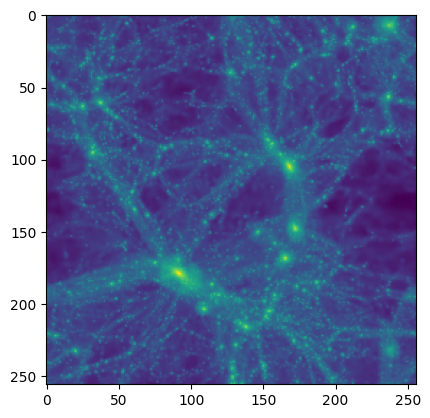

In [17]:
print(data[0].shape)
plt.imshow(data[0])

<ipython-input-8-6cee68ace8c6>:5: RuntimeWarning: invalid value encountered in true_divide
  norm = (img - np.amin(img)) / (np.amax(img) - np.amin(img))


1.0 -1.0


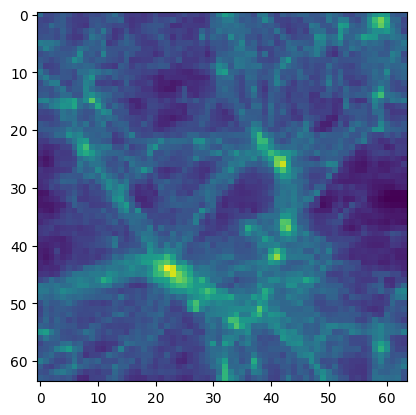

In [18]:
resized_data = np.zeros(shape = (15000, 64, 64))
for i in range(len(data)):
  resized_data[i] = cv2.resize(data[i], dsize = (64, 64), interpolation = cv2.INTER_AREA)
plt.imshow((resized_data[0]))

normalised_data = []
for i in range(len(resized_data)):
  n = normalise(resized_data[i])
  normalised_data.append(n)
normalised_data = np.float32(np.array(normalised_data))
plt.imshow((normalised_data[0])) #no log if its between 1 and -1.

print(np.max(normalised_data[0]), np.min(normalised_data[0]))

In [ ]:
dataset = CustomDataset(normalised_data, labels)
dataloader = DataLoader(dataset)
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['image'])


In [ ]:
model = UNet2DModel(
    sample_size = config.image_size,  # the target image resolution
    in_channels = 1,  # the number of input channels, 3 for RGB images
    out_channels = 1,  # the number of output channels
    layers_per_block = 2,  # how many ResNet layers to use per UNet block
    block_out_channels = (128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types = (
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types = (
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

x = dataset[0]["image"]
sample_image = x[None,None,:,:] #This adds the extra 1,1 in front of the 64, 64. The image does not have a channel value and it is not picked up anywhere.
assert sample_image.shape == (1,1,64,64) #This ensures that the tensor dimension works
sample_image.shape
sample_image.type(torch.FloatTensor) #Fixes an error to do with the tensors - in tandem with the float 32 part earlier
print('Input shape: ', sample_image.shape) #The input shape should match the output shape
#print(sample_image.type)
print(torch.min(sample_image)) #Check to see the lowest value - I got 0.0004
print('Output shape: ', model(sample_image, timestep = 0).sample.shape) #Output shape is somehow obtained

Input shape:  torch.Size([1, 1, 64, 64])
tensor(-1.)
Output shape:  torch.Size([1, 1, 64, 64])


tensor(-1.3434)


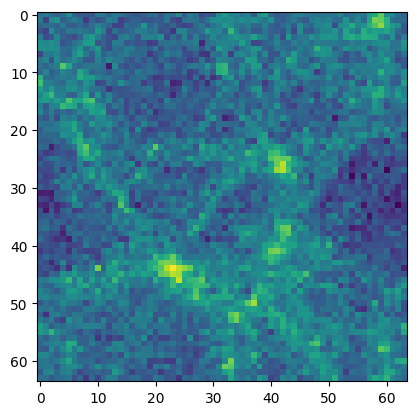

In [ ]:
###"IMPORTANT"###CHANGE BETA SCHEDULE FOR NOISING PATTERN
noise_scheduler = DDPMScheduler(num_train_timesteps = 1000, beta_schedule = 'linear') #squaredcos_cap_v2 #sigmoid #linear
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
#min value of sample_image is 0.0004
print(torch.min(noisy_image)) #tensor(-3.4771)...can noise values be negative? Causes issues in log
#print(noisy_image.shape) #1,1,64,64
perm = noisy_image.permute(0, 2, 3, 1).type(torch.float64).numpy()[0] #Noise pixels are white, since it is a 1 channel image - could be wrong
plt.imshow((((perm)))) #perm does not show noise unless logged (?)

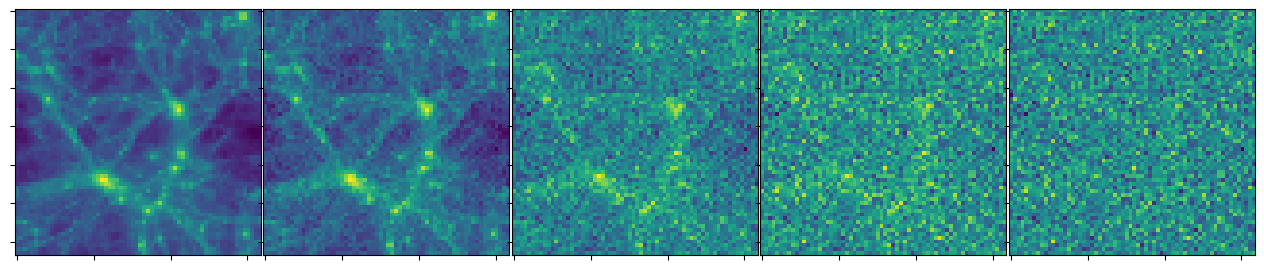

In [74]:
#this code is for demonstrating the noise schedule as a plot

plt.figure(figsize = (16,16))
grid = gridspec.GridSpec(1, 5)
grid.update(wspace=0.01, hspace=0.05)

noise_scheduler = DDPMScheduler(num_train_timesteps = 2000, beta_schedule = 'squaredcos_cap_v2')
noise = torch.randn(sample_image.shape)

for i in range(5):
  timesteps = torch.LongTensor([100 * i ** 2])
  noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
  perm = noisy_image.permute(0, 2, 3, 1).type(torch.float64).numpy()[0]

  ax1 = plt.subplot(grid[i])
  ax1.imshow(perm)
  plt.axis('on')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
plt.show()

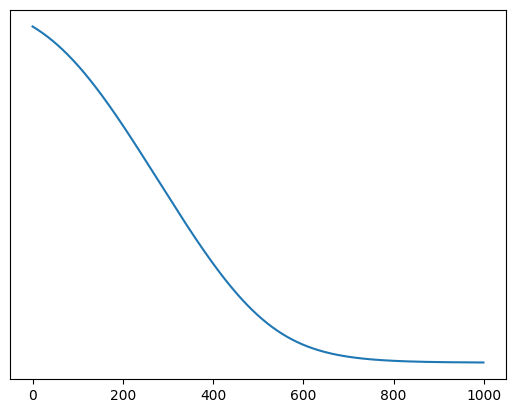

In [90]:
noise_scheduler = DDPMScheduler(num_train_timesteps = 1000, beta_schedule = 'sigmoid')
plt.plot(np.abs(np.log(np.array(noise_scheduler.betas))))
plt.yticks([])
plt.show()

In [ ]:
clean_images = batch['image']
print(clean_images.shape)
x = batch['image']
clean_images = x[None, :, :]
assert clean_images.shape == (1,1,64,64)
clean_images.type(torch.FloatTensor)
clean_images.shape

print("Input shape:", clean_images.shape)
#print(sample_image.type)
print(torch.min(clean_images))

torch.Size([1, 64, 64])
Input shape: torch.Size([1, 1, 64, 64])
tensor(-1.)


In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate) #try sigmoid for epsilon, 6464 to verify for adam
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)#replaced train_dataloader with norm_dataloader

In [ ]:
args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

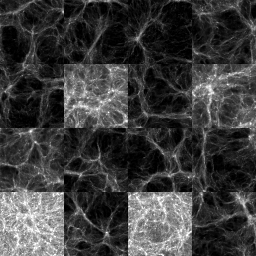

In [ ]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
ims = []
imsres = []
for k in glob.glob('/content/ddpm-IllustrisTNG-CV/samples/*.png'):
    i = Image.open(k)
    ims.append(i)
    ir = i.resize((512,512), Image.ANTIALIAS)
    imsres.append(ir)

<ipython-input-23-160b5d2b8194>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ir = i.resize((512,512), Image.ANTIALIAS)


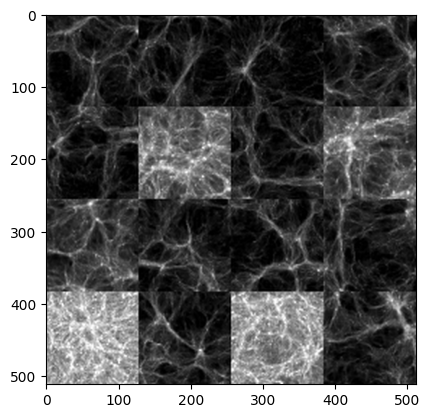

In [ ]:
plt.imshow(imsres[0])

<PIL.Image.Image image mode=L size=64x64 at 0x7AB398676230>


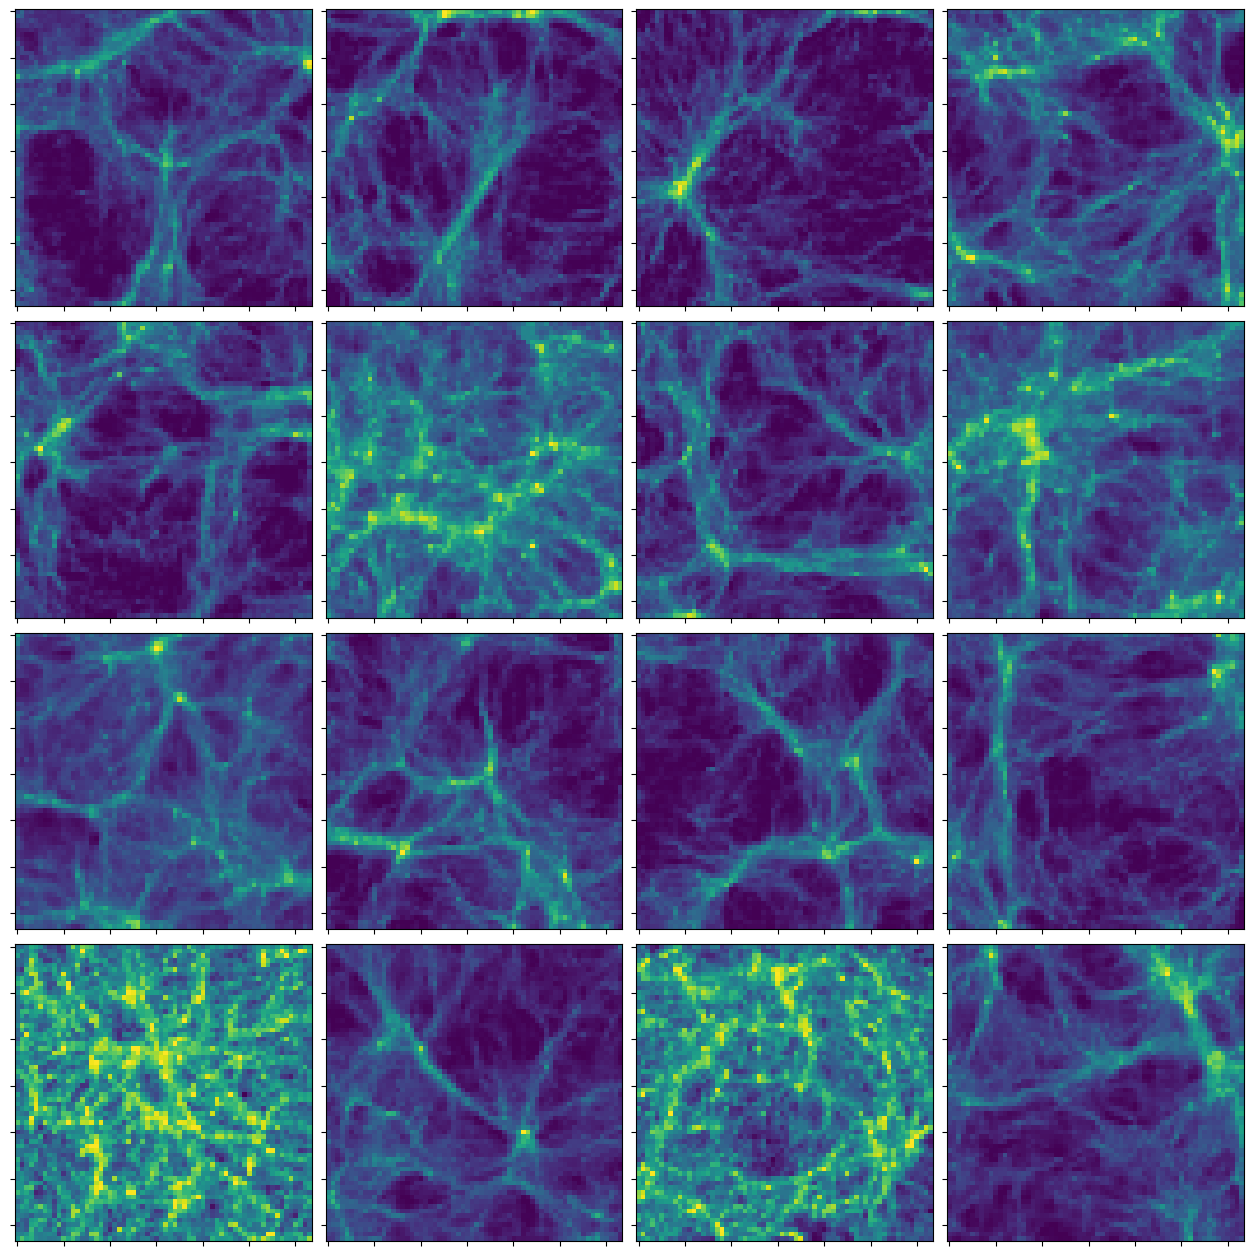

In [ ]:
image_tensors = torch.load("im_tens.pt")
len(image_tensors)
print(image_tensors[0])

plt.figure(figsize = (16,16))
grid = gridspec.GridSpec(4, 4)
grid.update(wspace=0.01, hspace=0.05)
output_images = []

for i in range(16):
    ax1 = plt.subplot(grid[i])
    ax1.imshow(image_tensors[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    output_images.append(np.array(image_tensors[i]))
plt.show()

In [24]:
linear = torch.load('results_linear.pt') #64x64, 80 epochs, linear
sigmoid = torch.load('results_sigmoid.pt') #64x64, 80 epochs, sigmoid
cosine = torch.load('results_sqcoscap.pt') #64x64, 80 epochs, squared cos cap

img_lin = []
img_sig = []
img_cos = []

for i in range(len(linear)):
  img_lin.append(normalise(np.array(linear[i])))
  img_sig.append(normalise(np.array(sigmoid[i])))
  img_cos.append(normalise(np.array(cosine[i])))

ks0, ms0 = [], []
ks1, ms1 = [], []
ks2, ms2 = [], []
ks3, ms3 = [], []

for i in range(len(linear)):
  k0, m0 = calc_1dps_img2d(normalised_data[i])
  k1, m1 = calc_1dps_img2d(img_lin[i])
  k2, m2 = calc_1dps_img2d(img_sig[i])
  k3, m3 = calc_1dps_img2d(img_cos[i])

  ks0.append(k0), ms0.append(m0)
  ks1.append(k1), ms1.append(m1)
  ks2.append(k2), ms2.append(m2)
  ks3.append(k3), ms3.append(m3)

ks0, ms0, ks1, ms1, ks2, ms2, ks3, ms3 = np.array(ks0), np.array(ms0), np.array(ks1), np.array(ms1) ,np.array(ks2), np.array(ms2), np.array(ks3), np.array(ms3)

mean0 = np.mean(ms0, axis=0)
mean1 = np.mean(ms1, axis=0)
mean2 = np.mean(ms2, axis=0)
mean3 = np.mean(ms3, axis=0)

(7.943282347242822e-07, 0.0031622776601683794)

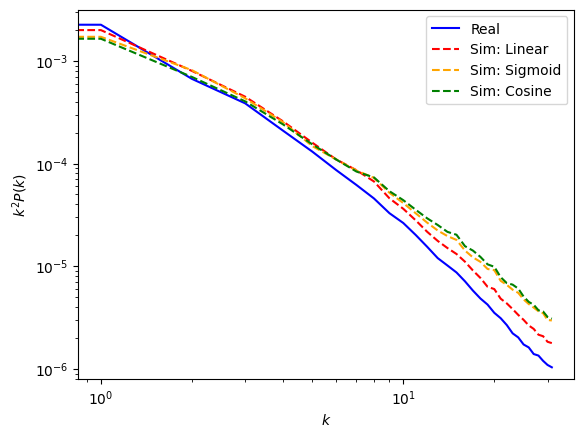

In [26]:
#FINAL GRAPH FOR AVERAGE POWER SPECTRA OF OUTPUTS VS AVERAGE POWER SPECTRA OF FIRST 32 INPUTS
k, m = calc_1dps_img2d(normalised_data[0])

fig = plt.figure()
ax = plt.axes()
plt.plot(k, mean0, 'blue', label = 'Real')
plt.plot(k, mean1, 'red', linestyle = 'dashed', label = 'Sim: Linear')
plt.plot(k, mean2, 'orange', linestyle = 'dashed', label = 'Sim: Sigmoid')
plt.plot(k, mean3, 'green', linestyle = 'dashed', label = 'Sim: Cosine')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'upper right')
ax.set_xlabel('$k$')
ax.set_ylabel('$k^{2}P(k)$')
ax.set_ylim(10**-6.1, 10**-2.5)

(7.943282347242822e-07, 0.0031622776601683794)

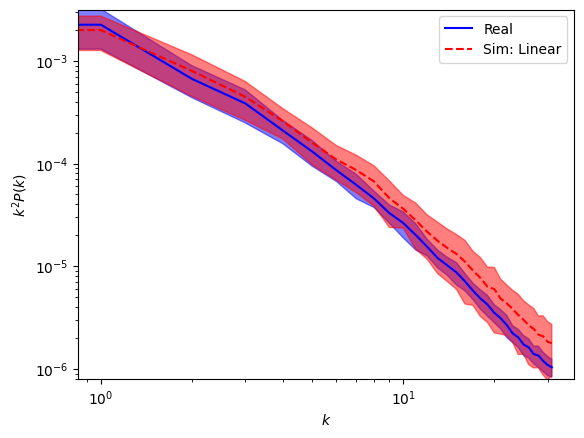

In [27]:
std0 = np.std(ms0, axis=0) #std of input, lin, sig, cos, respectively
std1 = np.std(ms1, axis=0)
std2 = np.std(ms2, axis=0)
std3 = np.std(ms3, axis=0)

#FINAL GRAPH FOR AVERAGE POWER SPECTRA OF OUTPUTS VS AVERAGE POWER SPECTRA OF FIRST 32 INPUTS
fig = plt.figure()
ax = plt.axes()
#ax.errorbar(k,res4, yerr=res4std) #res4 is input, res3 is output
#ax.errorbar(k,res3, yerr=res3std)
plt.plot(k, mean0, 'blue', label = 'Real')
plt.plot(k, mean1, 'red', linestyle = 'dashed', label='Sim: Linear')
plt.fill_between(k, mean0 - std0, mean0 + std0, color = 'blue', alpha = 0.5)
plt.fill_between(k, mean1 - std1, mean1 + std1, color = 'red', alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'upper right')
ax.set_xlabel('$k$')
ax.set_ylabel('$k^{2}P(k)$')
ax.set_ylim(10**-6.1, 10**-2.5)